In [ ]:
import numpy as np
import array
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [ ]:
!pip install river

In [ ]:
from river import metrics, ensemble, preprocessing
from river.forest import ARFClassifier
from river.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/AircompressorDataset_Raw.csv')

In [ ]:
class dataProcessing:
  def __init__(self, dfData,refinedColumns,target_Columns):  # Constructor method
        self.dfData = dfData.copy()
        self.dfRawData = dfData.copy()
        self.refinedColumns = refinedColumns
        self.target_Columns = target_Columns

  def __init__(self, dfData):  # Constructor method
        self.dfData = dfData.copy()
        self.dfRawData = dfData.copy()
        self.refinedColumns = None
        self.target_Columns = None

  def scaleData(self,dataX):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if self.refinedColumns is None:
      refinedX= dataX
    else:
      refinedX = self.dfData[self.refinedColumns]
    scaledX = scaler.fit_transform(refinedX)
    return scaledX

  def getX(self):
    columns_to_drop = ['bearings','wpump','radiator','exvalve','Timestamp']
    refinedX = self.dfData.drop(columns_to_drop, axis=1,errors='ignore')
    return refinedX

  def getProcessedX(self):
    return self.scaleData(self.getX())

  def getProcessedY(self,targetColumn):

    if targetColumn is not None:
      self.y = self.dfRawData[targetColumn]
    elif self.target_Columns is not None:
      self.y = self.dfRawData[self.target_Columns]
    else:
      self.y = self.dfRawData['bearings']
    return self.y

  def getDuplicateValueCount(self):
    dupes = self.dfData.duplicated()
    return sum(dupes)

  def get_summary(self):
    """Return basic statistics."""
    return self.dfData.describe()

  def dropColumns(self,columnsToRemove):
    self.dfData.drop(columnsToRemove, axis=1,errors='ignore', inplace=True)

  def get_rawdata(self):
    return self.dfRawData

  def get_data(self):
    return self.dfData

  def getMissingValueList(self):
    return pd.DataFrame( self.dfData.isnull().sum(), columns= ['Number of missing values'])

  def addTimestamp(self):
    now = datetime.now()
    histEdDate = now - timedelta(days=3)
    histStDate = histEdDate - timedelta(days=(len(self.dfData)/24))

    formatted_time = histStDate.strftime("%Y-%m-%d %H:%M:%S")
    formatted_time = pd.to_datetime(formatted_time)
    self.dfData['Timestamp'] = [formatted_time + pd.Timedelta(hours=i) for i in range(len(self.dfData))]

In [ ]:
dataProcessor = dataProcessing(df)

**Data Analysis**

In [ ]:
dataProcessor.get_rawdata().shape

(1000, 26)

In [ ]:
dataProcessor.get_rawdata().head()

,id,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,...,gaccy,gaccz,haccx,haccy,haccz,bearings,wpump,radiator,exvalve,acmotor
0,1,499,1405.842858,27.511708,1.000,308.289879,40.840517,78.554715,2.960632,43.166392,...,0.383773,2.649801,1.213344,1.409218,2.962484,0,0,0,0,Stable
1,2,513,1457.370092,31.030115,1.081,307.833736,40.484226,76.902822,2.536711,47.342143,...,0.450954,2.669423,1.210674,1.379050,2.938135,0,0,0,0,Stable
2,3,495,1582.249959,33.484653,1.369,307.377593,40.918572,77.547021,2.112789,49.306593,...,0.443924,2.772009,1.210612,1.373490,2.991878,0,0,0,0,Stable
3,4,480,1712.466820,36.394475,1.691,306.975248,40.450953,80.059949,2.087534,46.886933,...,0.370457,2.876056,1.213223,1.443234,3.096158,0,0,0,0,Stable
4,5,498,1766.035170,38.249154,1.731,306.832132,41.233739,79.130424,2.338877,50.498100,...,0.383868,2.849451,1.209216,1.405190,3.059417,0,0,0,0,Stable


In [ ]:
dataProcessor.getMissingValueList()

,Number of missing values
id,0
rpm,0
motor_power,0
torque,0
outlet_pressure_bar,0
air_flow,0
noise_db,0
outlet_temp,0
wpump_outlet_press,0
water_inlet_temp,0


Data Analysis: Label Analysis

In [ ]:
initialTargetColumns= ['bearings','wpump','radiator','exvalve','acmotor']

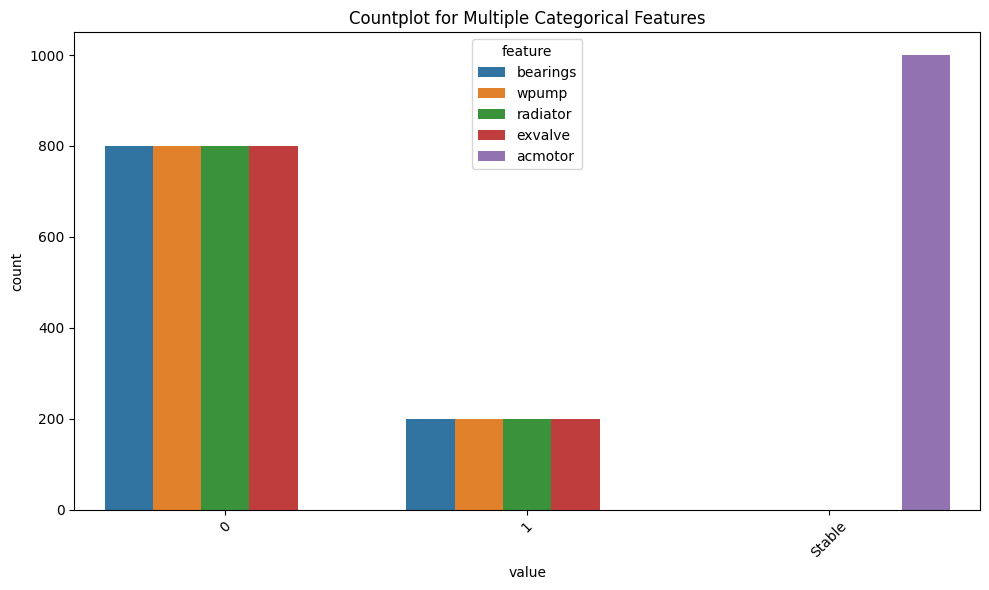

In [ ]:
import seaborn as sns
#sns.countplot(x=['bearings','wpump','radiator','exvalve','acmotor'], data=dataProcessor.get_rawdata())
df_melted = dataProcessor.get_rawdata().melt(value_vars=initialTargetColumns, var_name='feature', value_name='value')
plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='value', hue='feature')
plt.title("Countplot for Multiple Categorical Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


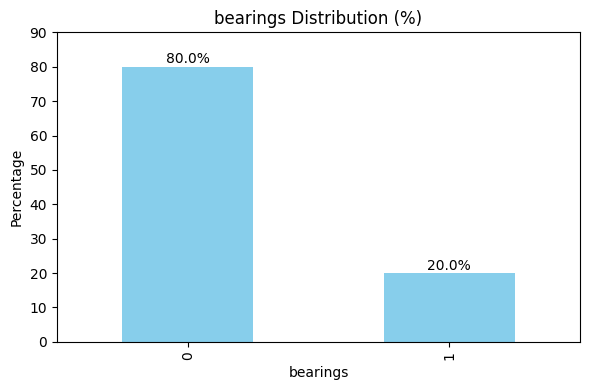

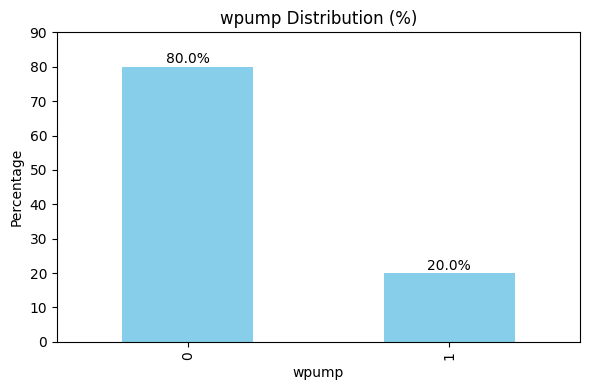

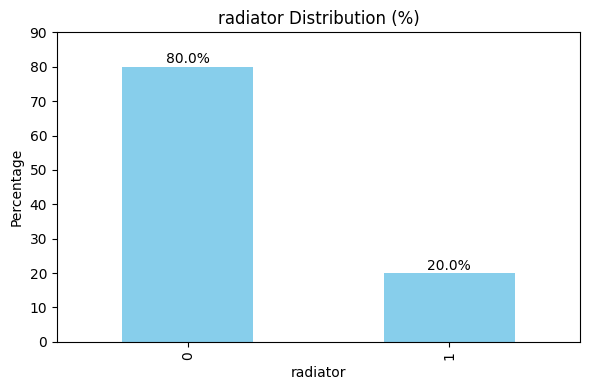

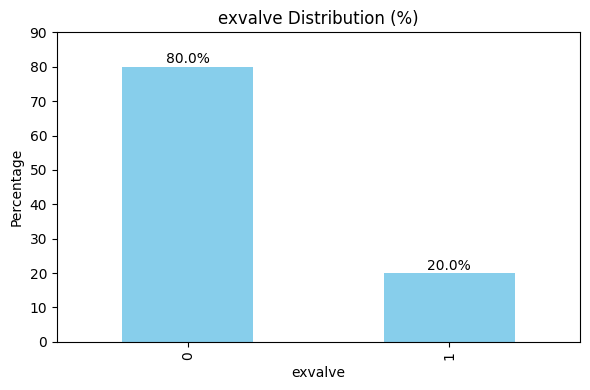

In [ ]:


# Plot percentage distribution for each
for col in initialTargetColumns:
    plt.figure(figsize=(6, 4))
    percent = dataProcessor.get_rawdata()[col].value_counts(normalize=True) * 100
    percent.plot(kind='bar', color='skyblue')

    # Add percentage labels
    for i, value in enumerate(percent):
        plt.text(i, value + 1, f'{value:.1f}%', ha='center')

    plt.title(f'{col} Distribution (%)')
    plt.ylabel('Percentage')
    plt.xlabel(col)
    plt.ylim(0, percent.max() + 10)
    plt.tight_layout()
    plt.show()

In [ ]:
columns_to_drop = ['id','acmotor']
dataProcessor.dropColumns(columns_to_drop)
dataProcessor.get_data().head()

,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,water_outlet_temp,...,gaccx,gaccy,gaccz,haccx,haccy,haccz,bearings,wpump,radiator,exvalve
0,499,1405.842858,27.511708,1.000,308.289879,40.840517,78.554715,2.960632,43.166392,47.259238,...,0.711820,0.383773,2.649801,1.213344,1.409218,2.962484,0,0,0,0
1,513,1457.370092,31.030115,1.081,307.833736,40.484226,76.902822,2.536711,47.342143,55.025653,...,0.704667,0.450954,2.669423,1.210674,1.379050,2.938135,0,0,0,0
2,495,1582.249959,33.484653,1.369,307.377593,40.918572,77.547021,2.112789,49.306593,50.505622,...,0.704828,0.443924,2.772009,1.210612,1.373490,2.991878,0,0,0,0
3,480,1712.466820,36.394475,1.691,306.975248,40.450953,80.059949,2.087534,46.886933,58.706376,...,0.726604,0.370457,2.876056,1.213223,1.443234,3.096158,0,0,0,0
4,498,1766.035170,38.249154,1.731,306.832132,41.233739,79.130424,2.338877,50.498100,54.046362,...,0.707785,0.383868,2.849451,1.209216,1.405190,3.059417,0,0,0,0


In [ ]:
initialTargetColumns= ['bearings','wpump','radiator','exvalve']
(df[initialTargetColumns].sum() / len(dataProcessor.get_data())).sort_values(ascending=False)

,0
bearings,0.2
wpump,0.2
radiator,0.2
exvalve,0.2


In [ ]:
dataProcessor.get_data()[initialTargetColumns].astype(int).corr()

,bearings,wpump,radiator,exvalve
bearings,1.00,-0.25,-0.25,-0.25
wpump,-0.25,1.00,-0.25,-0.25
radiator,-0.25,-0.25,1.00,-0.25
exvalve,-0.25,-0.25,-0.25,1.00


Feature Analysis

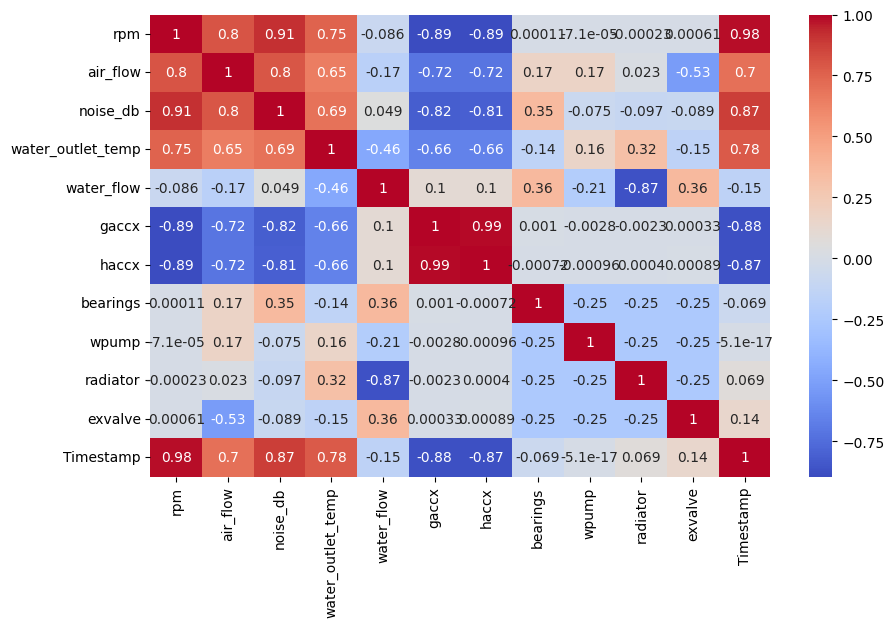

In [ ]:
corr = dataProcessor.get_data().corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

we see items with high corelation , only item greated than .9 is noice_db and rpm

In [ ]:
dataProcessor.get_summary()

,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,water_outlet_temp,...,gaccx,gaccy,gaccz,haccx,haccy,haccz,bearings,wpump,radiator,exvalve
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.0000,1000.0000,1000.0000
mean,1499.516000,6984.877371,49.186120,4.054049,754.673930,53.412121,118.855110,2.799610,83.021711,96.636589,...,0.601789,0.349667,3.923073,1.101253,1.350042,3.495037,0.2000,0.2000,0.2000,0.2000
std,707.681915,4269.277571,18.706750,1.862761,442.743491,8.055363,19.120181,0.455274,18.644992,20.557276,...,0.058719,0.040667,1.610130,0.058546,0.040871,0.817667,0.4002,0.4002,0.4002,0.4002
min,480.000000,1402.424603,13.222197,1.000000,95.098952,39.879017,76.902822,1.834533,43.166392,47.259238,...,0.540045,0.274650,1.730301,1.039910,1.270696,2.329267,0.0000,0.0000,0.0000,0.0000
25%,988.750000,3559.437042,33.749857,2.443750,305.388152,46.490976,104.731080,2.448208,68.914714,81.365268,...,0.558092,0.316543,2.576739,1.057717,1.318785,2.802622,0.0000,0.0000,0.0000,0.0000
50%,1500.000000,5906.662534,48.890905,4.038000,608.626411,52.708480,118.275842,2.780492,82.101660,96.084809,...,0.576814,0.349343,3.610639,1.075392,1.348189,3.339698,0.0000,0.0000,0.0000,0.0000
75%,2010.000000,9636.002782,63.672921,5.600250,1193.266273,60.158248,132.850790,3.092101,95.792346,110.989064,...,0.615021,0.375261,5.081960,1.113696,1.375232,4.071874,0.0000,0.0000,0.0000,0.0000
max,2520.000000,19454.559080,93.540405,8.664000,1539.911634,74.401986,172.711382,4.295136,137.543531,161.123805,...,0.726604,0.459811,9.209166,1.227134,1.461809,6.107852,1.0000,1.0000,1.0000,1.0000


/tmp/ipython-input-3352631726.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')


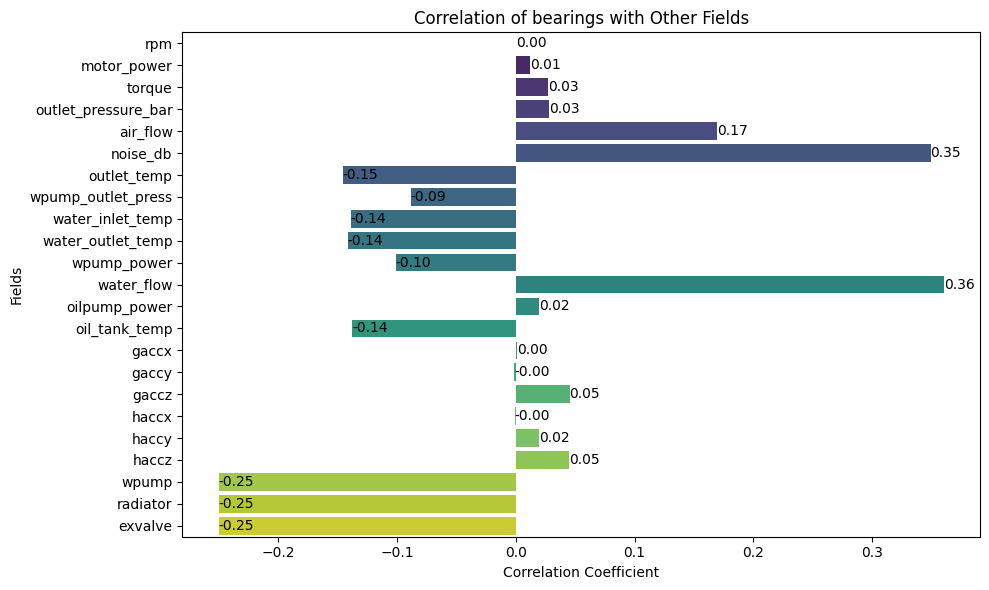

In [ ]:
# Specify the field you want to check correlation for
#target_field = 'bearings'  # Replace with your actual column name
target_field = 'bearings'  # Replace with your actual column name

# Compute correlation matrix
correlation_matrix = dataProcessor.get_data().corr(numeric_only=True)

# Extract correlation of the target field with others
target_correlations = correlation_matrix[target_field].drop(labels=[target_field])

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')

# Add value labels to each bar
for i, value in enumerate(target_correlations.values):
    barplot.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')

plt.title(f'Correlation of {target_field} with Other Fields')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Fields')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2785231359.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')


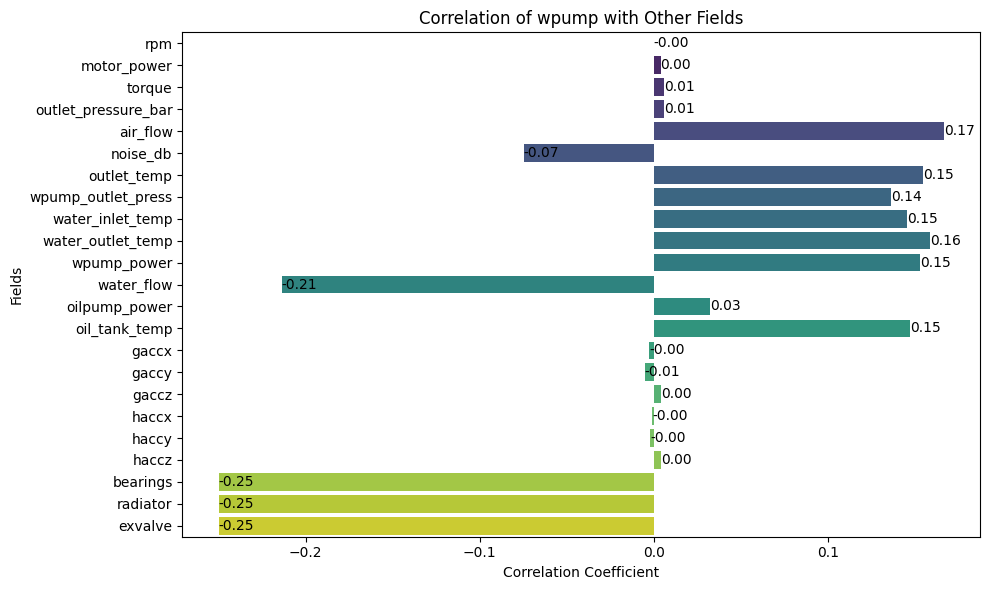

In [ ]:
# Specify the field you want to check correlation for
#target_field = 'bearings'  # Replace with your actual column name
target_field = 'wpump'  # Replace with your actual column name

# Compute correlation matrix
correlation_matrix = dataProcessor.get_data().corr(numeric_only=True)

# Extract correlation of the target field with others
target_correlations = correlation_matrix[target_field].drop(labels=[target_field])

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')

# Add value labels to each bar
for i, value in enumerate(target_correlations.values):
    barplot.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')

plt.title(f'Correlation of {target_field} with Other Fields')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Fields')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1623740539.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')


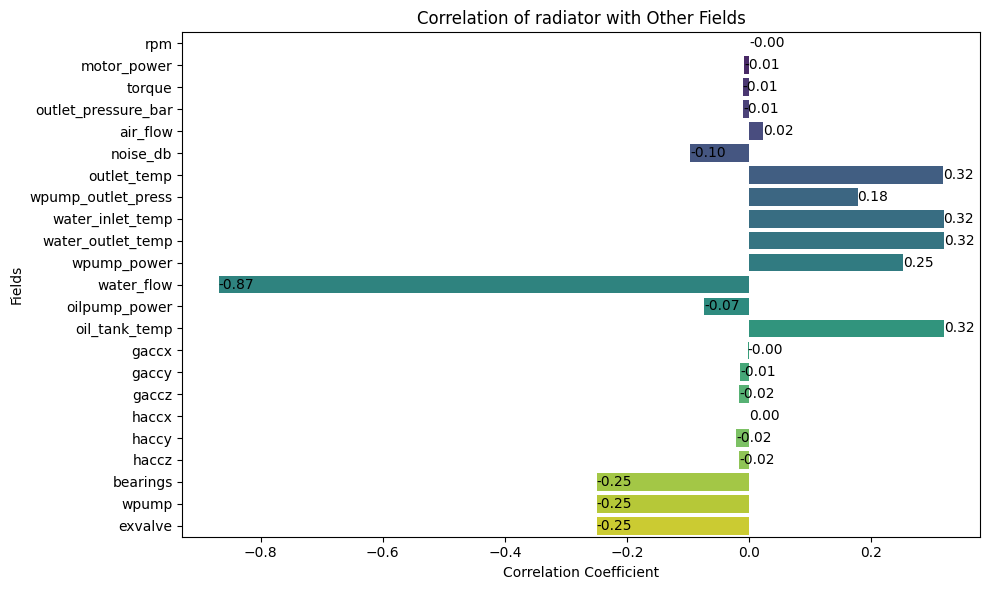

In [ ]:
target_field = 'radiator'  # Replace with your actual column name

# Compute correlation matrix
correlation_matrix = dataProcessor.get_data().corr(numeric_only=True)

# Extract correlation of the target field with others
target_correlations = correlation_matrix[target_field].drop(labels=[target_field])

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')

# Add value labels to each bar
for i, value in enumerate(target_correlations.values):
    barplot.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')

plt.title(f'Correlation of {target_field} with Other Fields')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Fields')
plt.tight_layout()
plt.show()

/tmp/ipython-input-951743173.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')


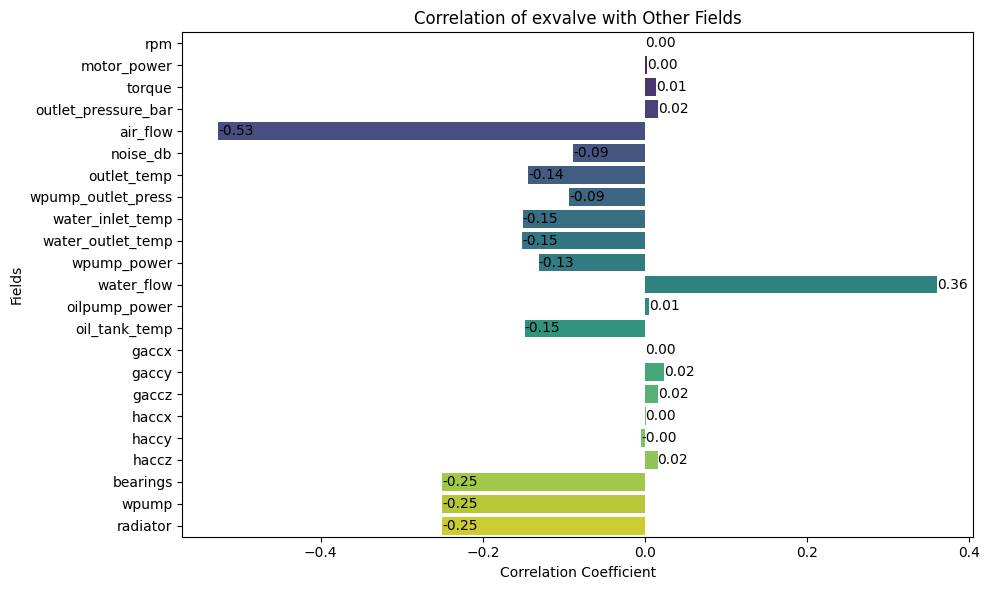

In [ ]:
target_field = 'exvalve'  # Replace with your actual column name

# Compute correlation matrix
correlation_matrix = dataProcessor.get_data().corr(numeric_only=True)

# Extract correlation of the target field with others
target_correlations = correlation_matrix[target_field].drop(labels=[target_field])

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')

# Add value labels to each bar
for i, value in enumerate(target_correlations.values):
    barplot.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')

plt.title(f'Correlation of {target_field} with Other Fields')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Fields')
plt.tight_layout()
plt.show()

Add Timestamp for Historical Trending

In [ ]:
dataProcessor.addTimestamp()

In [ ]:
dataProcessor.get_data()['Timestamp'].describe()

,Timestamp
count,1000
mean,2025-09-19 03:36:01.999999744
min,2025-08-29 08:06:02
25%,2025-09-08 17:51:02
50%,2025-09-19 03:36:02
75%,2025-09-29 13:21:02
max,2025-10-09 23:06:02


# New Section

In [ ]:
dataProcessor.get_data().head()

,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,water_outlet_temp,...,gaccy,gaccz,haccx,haccy,haccz,bearings,wpump,radiator,exvalve,Timestamp
0,499,1405.842858,27.511708,1.000,308.289879,40.840517,78.554715,2.960632,43.166392,47.259238,...,0.383773,2.649801,1.213344,1.409218,2.962484,0,0,0,0,2025-08-29 08:06:02
1,513,1457.370092,31.030115,1.081,307.833736,40.484226,76.902822,2.536711,47.342143,55.025653,...,0.450954,2.669423,1.210674,1.379050,2.938135,0,0,0,0,2025-08-29 09:06:02
2,495,1582.249959,33.484653,1.369,307.377593,40.918572,77.547021,2.112789,49.306593,50.505622,...,0.443924,2.772009,1.210612,1.373490,2.991878,0,0,0,0,2025-08-29 10:06:02
3,480,1712.466820,36.394475,1.691,306.975248,40.450953,80.059949,2.087534,46.886933,58.706376,...,0.370457,2.876056,1.213223,1.443234,3.096158,0,0,0,0,2025-08-29 11:06:02
4,498,1766.035170,38.249154,1.731,306.832132,41.233739,79.130424,2.338877,50.498100,54.046362,...,0.383868,2.849451,1.209216,1.405190,3.059417,0,0,0,0,2025-08-29 12:06:02


In [ ]:
dataProcessor.get_data().describe()

,rpm,air_flow,noise_db,water_outlet_temp,water_flow,gaccx,haccx,bearings,wpump,radiator,exvalve,Timestamp
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.0000,1000.0000,1000.0000,1000
mean,1499.516000,754.673930,53.412121,96.636589,53.708176,0.601789,1.101253,0.2000,0.2000,0.2000,0.2000,2025-09-19 03:36:01.999999744
min,480.000000,95.098952,39.879017,47.259238,38.570791,0.540045,1.039910,0.0000,0.0000,0.0000,0.0000,2025-08-29 08:06:02
25%,988.750000,305.388152,46.490976,81.365268,50.459245,0.558092,1.057717,0.0000,0.0000,0.0000,0.0000,2025-09-08 17:51:02
50%,1500.000000,608.626411,52.708480,96.084809,58.112667,0.576814,1.075392,0.0000,0.0000,0.0000,0.0000,2025-09-19 03:36:02
75%,2010.000000,1193.266273,60.158248,110.989064,58.552897,0.615021,1.113696,0.0000,0.0000,0.0000,0.0000,2025-09-29 13:21:02
max,2520.000000,1539.911634,74.401986,161.123805,59.174992,0.726604,1.227134,1.0000,1.0000,1.0000,1.0000,2025-10-09 23:06:02
std,707.681915,442.743491,8.055363,20.557276,6.587259,0.058719,0.058546,0.4002,0.4002,0.4002,0.4002,NaN


Data Scalling -Bearings

In [ ]:
processedX = dataProcessor.getProcessedX()
print("\nScaled Data:\n", processedX)

processedY = dataProcessor.getProcessedY('bearings')
print("\Y Data:\n", processedY)


Scaled Data:
 [[-1.4145008  -1.30744044 -1.15922099 ...  1.91552506  1.44859039
  -0.65163454]
 [-1.394708   -1.29536509 -0.97104469 ...  1.8698883   0.71010837
  -0.68142826]
 [-1.42015588 -1.26609963 -0.83976766 ...  1.86883594  0.57398587
  -0.61566805]
 ...
 [ 1.43424835  2.76532737  1.20751752 ... -0.77118433  0.19699858
   1.66590109]
 [ 1.40031784  2.72499691  1.27888144 ... -0.84318598 -0.00866313
   1.65961504]
 [ 1.41304179  2.92225582  1.59073712 ... -0.88887793  0.1437152
   1.93794939]]
\Y Data:
 0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: bearings, Length: 1000, dtype: int64


<>:5: SyntaxWarning: invalid escape sequence '\Y'
<>:5: SyntaxWarning: invalid escape sequence '\Y'
/tmp/ipython-input-3603985226.py:5: SyntaxWarning: invalid escape sequence '\Y'
  print("\Y Data:\n", processedY)


Use Random Forest Classifier for selection of features using feature importance

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = dataProcessor.getX().columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

                Feature  Importance
5              noise_db    0.333711
11           water_flow    0.115802
4              air_flow    0.093639
14                gaccx    0.037514
0                   rpm    0.035230
9     water_outlet_temp    0.033758
13        oil_tank_temp    0.031050
17                haccx    0.029365
7    wpump_outlet_press    0.028250
6           outlet_temp    0.028092
3   outlet_pressure_bar    0.027625
8      water_inlet_temp    0.025445
16                gaccz    0.025407
10          wpump_power    0.024963
19                haccz    0.024664
12        oilpump_power    0.022578
2                torque    0.022451
15                gaccy    0.022373
18                haccy    0.020476
1           motor_power    0.017607


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9466666666666667
Precision: 0.9483747276688452
Recall: 0.9466666666666667
F1 Score: 0.9438296112489661
Confusion Matrix:
 [[240   1]
 [ 15  44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       241
           1       0.98      0.75      0.85        59

    accuracy                           0.95       300
   macro avg       0.96      0.87      0.91       300
weighted avg       0.95      0.95      0.94       300



In [ ]:
processedX = dataProcessor.getProcessedX()
processedY = dataProcessor.getProcessedY('wpump')


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = dataProcessor.getX().columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[232   0]
 [  0  68]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00        68

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [ ]:
processedX = dataProcessor.getProcessedX()
processedY = dataProcessor.getProcessedY('radiator')


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = dataProcessor.getX().columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[240   0]
 [  0  60]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [ ]:
processedX = dataProcessor.getProcessedX()
processedY = dataProcessor.getProcessedY('exvalve')


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = dataProcessor.getX().columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[247   0]
 [  0  53]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00        53

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Based on dataset other than label bearing , others are showing far too perfect scores, will tale beating label for reaearch,

Drop columns with less importance

In [ ]:
columns_to_drop = ['outlet_temp','water_inlet_temp','oil_tank_temp','wpump_outlet_press','outlet_pressure_bar','haccz','gaccy','gaccz','oilpump_power','wpump_power','torque','haccy','motor_power']
dataProcessor.dropColumns(columns_to_drop)
dataProcessor.get_data().head()

,rpm,air_flow,noise_db,water_outlet_temp,water_flow,gaccx,haccx,bearings,wpump,radiator,exvalve,Timestamp
0,499,308.289879,40.840517,47.259238,59.085059,0.711820,1.213344,0,0,0,0,2025-08-29 08:06:02
1,513,307.833736,40.484226,55.025653,59.161939,0.704667,1.210674,0,0,0,0,2025-08-29 09:06:02
2,495,307.377593,40.918572,50.505622,59.041939,0.704828,1.210612,0,0,0,0,2025-08-29 10:06:02
3,480,306.975248,40.450953,58.706376,59.037176,0.726604,1.213223,0,0,0,0,2025-08-29 11:06:02
4,498,306.832132,41.233739,54.046362,59.164154,0.707785,1.209216,0,0,0,0,2025-08-29 12:06:02


In [ ]:
processedX = dataProcessor.getProcessedX()
print("\nScaled Data:\n", processedX)

processedY = dataProcessor.getProcessedY('bearings')
print("\Y Data:\n", processedY)


Scaled Data:
 [[-1.4145008  -1.00872722 -1.56143118 ...  0.81666342  1.87480872
   1.91552506]
 [-1.394708   -1.009758   -1.60568352 ...  0.82834019  1.75292856
   1.8698883 ]
 [-1.42015588 -1.01078878 -1.55173648 ...  0.81011421  1.75566778
   1.86883594]
 ...
 [ 1.43424835 -0.63464138  0.8703913  ...  0.61877494 -0.78307588
  -0.77118433]
 [ 1.40031784 -0.64692657  1.07520579 ...  0.60621173 -0.81526948
  -0.84318598]
 [ 1.41304179 -0.64370274  1.05465735 ...  0.626634   -0.93233078
  -0.88887793]]
\Y Data:
 0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: bearings, Length: 1000, dtype: int64


<>:5: SyntaxWarning: invalid escape sequence '\Y'
<>:5: SyntaxWarning: invalid escape sequence '\Y'
/tmp/ipython-input-3603985226.py:5: SyntaxWarning: invalid escape sequence '\Y'
  print("\Y Data:\n", processedY)


In [ ]:
type(processedX)
formatted = np.array_str(processedX, precision=2, suppress_small=True)
print(formatted)

[[-1.41 -1.01 -1.56 ...  0.82  1.87  1.92]
 [-1.39 -1.01 -1.61 ...  0.83  1.75  1.87]
 [-1.42 -1.01 -1.55 ...  0.81  1.76  1.87]
 ...
 [ 1.43 -0.63  0.87 ...  0.62 -0.78 -0.77]
 [ 1.4  -0.65  1.08 ...  0.61 -0.82 -0.84]
 [ 1.41 -0.64  1.05 ...  0.63 -0.93 -0.89]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.3, random_state=42)

In [ ]:
dataProcessor.getX().columns

Index(['rpm', 'air_flow', 'noise_db', 'water_outlet_temp', 'water_flow',
       'gaccx', 'haccx'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = dataProcessor.getX().columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df)

             Feature  Importance
2           noise_db    0.440933
4         water_flow    0.161077
1           air_flow    0.121288
5              gaccx    0.084922
3  water_outlet_temp    0.064573
6              haccx    0.063804
0                rpm    0.063401


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667
Precision: 0.9866666666666667
Recall: 0.9866666666666667
F1 Score: 0.9866666666666667
Confusion Matrix:
 [[239   2]
 [  2  57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       241
           1       0.97      0.97      0.97        59

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



Function for ARF Incremental Classification Model

In [ ]:
class incrementalLearning:
    def __init__(self, dfDataX,dfDataY,model,target_Columns):  # Constructor method
        self.dfDataX = dfDataX
        self.dfDataY = dfDataY
        self.model =  model
        self.target_Columns = target_Columns

        self.accuracy = metrics.Accuracy()
        self.f1 = metrics.F1()
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()
        self.conf_matrix =metrics.ConfusionMatrix()
        self.kappa = metrics.CohenKappa()

        self.y_true = []
        self.y_scores = []


    def __init__(self, dfDataX,dfDataY,target_Columns):  # Constructor method
        self.dfDataX = dfDataX
        self.dfDataY = dfDataY
        self.target_Columns = target_Columns

        self.accuracy = metrics.Accuracy()
        self.f1 = metrics.F1()
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()
        self.conf_matrix = metrics.ConfusionMatrix()
        self.kappa = metrics.CohenKappa()

        self.model11 = StandardScaler() | ARFClassifier(seed=42,n_models=6,drift_detector=None)

        self.y_true = []
        self.y_scores = []

    def setModel(self,model):
        self.model11 = model

    def getModel(self):
        return self.model11

    def resetMetrices(self):
        self.accuracy = metrics.Accuracy()
        self.f1 = metrics.F1()
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def processXData(self,dfNewDataX):
      if dfNewDataX is not None:
         pDataX= pd.DataFrame(dfNewDataX)
      else:
         pDataX= pd.DataFrame(self.dfDataX)
      self.processedX = pDataX.to_dict(orient='records')
      print(type(self.processedX))

    def processYData(self,dfNewDataY):
      if dfNewDataY is not None:
        pDataY= pd.DataFrame(dfNewDataY)
      else:
        pDataY= pd.DataFrame(self.dfDataY)
      self.processedY = pDataY[self.target_Columns].tolist()

    def getLastProcessedData(self):
        return self.processedX,self.processedY;

    def learn(self):            # Instance method
        for x, y in zip(self.processedX,self.processedY):
          self.model11.learn_one(x, y)

    def predict(self):  # Another method
        for x in zip(self.processedX):
          y_pred = self.model11.predict_one(x)
          return y_pred

    def getMetrices(self):  # Another method

        for x, y in zip(self.processedX,self.processedY):
          y_predp = self.model11.predict_proba_one(x)
          y_pred = self.model11.predict_one(x)
          prob = y_predp.get(True, 0.0)  # Probability of class True
          self.y_true.append(y)
          self.y_scores.append(prob)
          self.accuracy.update(y, y_pred)
          self.f1.update(y, y_pred)
          self.precision.update(y, y_pred)
          self.recall.update(y, y_pred)
          self.conf_matrix.update(y_true=y, y_pred=y_pred)
          self.kappa.update(y_true=y, y_pred=y_pred)
        print(f"Accuracy:  {self.kappa.get():.4f}")
        print(f"Kappa:  {self.accuracy.get():.4f}")
        print(f"F1 Score:  {self.f1.get():.4f}")
        print(f"Precision: {self.precision.get():.4f}")
        print(f"Recall:    {self.recall.get():.4f}")
        print("📊 Confusion Matrix:")
        print(self.conf_matrix)
        return self.accuracy,self.kappa,self.f1,self.precision,self.recall,self.conf_matrix

    def getThresholdConfidence(self):
      precision = []
      recall = []
      f1Score = []
      threshold = []

      for t in [0.1 * i for i in range(1, 10)]:
        y_pred = [1 if p >= t else 0 for p in  self.y_scores]
        threshold.append(t)
        precision.append(precision_score(self.y_true, y_pred))
        recall.append(recall_score(self.y_true, y_pred))
        f1Score.append(f1_score(self.y_true, y_pred))
        print(f"Threshold: {t:.1f} | Precision: {precision_score(self.y_true, y_pred):.2f} | Recall: {recall_score(self.y_true, y_pred):.2f} | F1Score: {f1_score(self.y_true, y_pred)}")
      return precision,recall,f1Score,threshold

    def getAccuracy(self):
        return self.accuracy.get()

    def getF1(self):
        return self.f1.get()

    def getPrecision(self):
        return self.precision.get()

    def getRecall(self):
        return self.recall.get()

    def getKappa(self):
        return self.kappa.get()

    def getConfMatrix(self):
        return self.conf_matrix

In [ ]:
incrementalLearning = incrementalLearning(X_train,y_train,'bearings')

In [ ]:
incrementalLearning.processXData(None)
incrementalLearning.processYData(None)

<class 'list'>


In [ ]:
incrementalLearning.learn()

In [ ]:
incrementalLearning.processXData(X_test)
incrementalLearning.processYData(y_test)

<class 'list'>


In [ ]:
predictedValues = incrementalLearning.getMetrices()

Accuracy:  0.8545
Kappa:  0.9567
F1 Score:  0.8807
Precision: 0.9600
Recall:    0.8136
📊 Confusion Matrix:
    0     1   
0   239    2  
1    11   48  


In [ ]:
precision,recall,f1Score,t =incrementalLearning.getThresholdConfidence()

Threshold: 0.1 | Precision: 0.43 | Recall: 1.00 | F1Score: 0.6020408163265306
Threshold: 0.2 | Precision: 0.57 | Recall: 1.00 | F1Score: 0.7239263803680982
Threshold: 0.3 | Precision: 0.74 | Recall: 0.97 | F1Score: 0.8382352941176471
Threshold: 0.4 | Precision: 0.88 | Recall: 0.86 | F1Score: 0.8717948717948718
Threshold: 0.5 | Precision: 0.96 | Recall: 0.81 | F1Score: 0.8807339449541285
Threshold: 0.6 | Precision: 1.00 | Recall: 0.64 | F1Score: 0.7835051546391752
Threshold: 0.7 | Precision: 1.00 | Recall: 0.46 | F1Score: 0.627906976744186
Threshold: 0.8 | Precision: 1.00 | Recall: 0.27 | F1Score: 0.4266666666666667
Threshold: 0.9 | Precision: 1.00 | Recall: 0.17 | F1Score: 0.2898550724637681


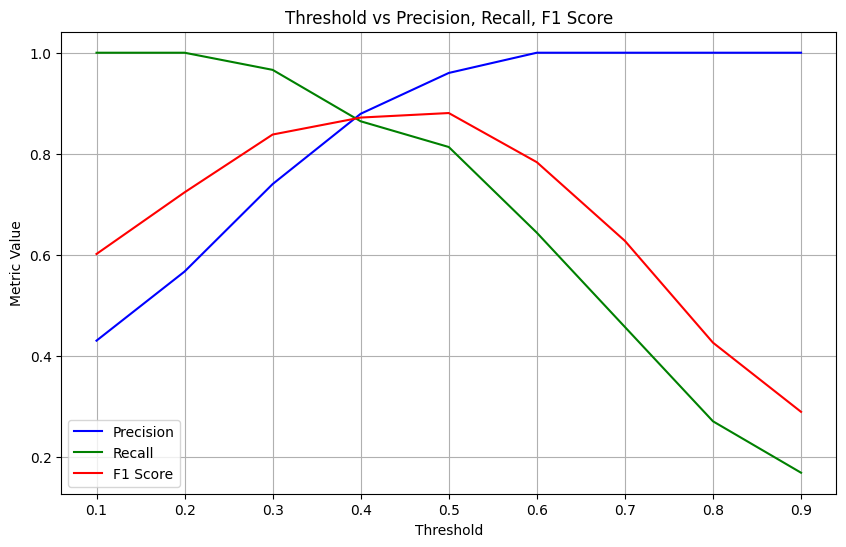

In [ ]:
thresholds = t
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1Score, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processedX, processedY, test_size=0.5, random_state=42)

In [ ]:
incrementalLearning.processXData(X_test)
incrementalLearning.processYData(y_test)

<class 'list'>


In [ ]:
predictedValues = incrementalLearning.getMetrices()

Accuracy:  0.8414
Kappa:  0.9537
F1 Score:  0.8693
Precision: 0.9535
Recall:    0.7987
📊 Confusion Matrix:
    0     1    
0   640     6  
1    31   123  


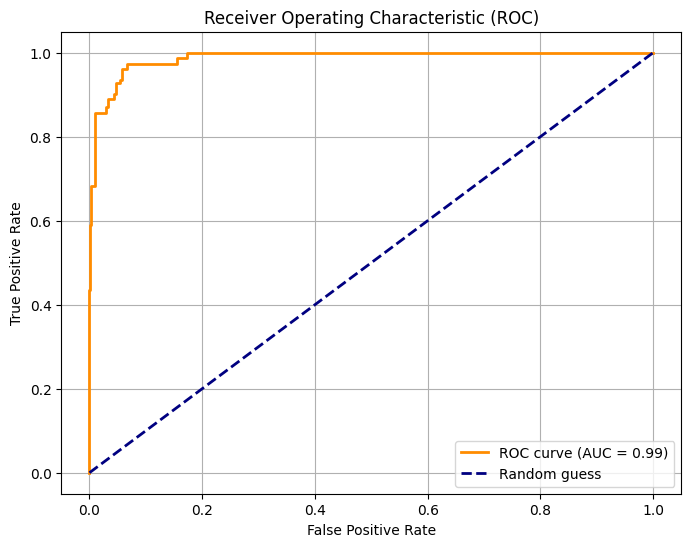

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(incrementalLearning.y_true, incrementalLearning.y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

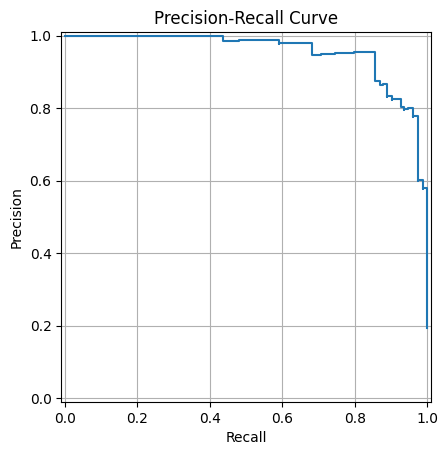

In [ ]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(incrementalLearning.y_true, incrementalLearning.y_scores)

# Plot using PrecisionRecallDisplay
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()